# scVI-tools (single-cell variational inference tools)
[공식 문서](https://docs.scvi-tools.org/en/stable/user_guide/index.html)

In [1]:
import scanpy as sc
import scvi
from matplotlib import rcParams

# Load data

In [6]:
# folder_path = "C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/sc/"
folder_path = "C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/concat/"
adata = sc.read(folder_path + "adata_processed.h5ad")

In [7]:
adata

AnnData object with n_obs × n_vars = 278304 × 44974
    obs: 'sample', 'n_genes', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo'
    var: 'n_cells'
    layers: 'counts'

In [8]:
sc.pp.filter_genes(adata, min_cells=30)
adata

AnnData object with n_obs × n_vars = 278304 × 34234
    obs: 'sample', 'n_genes', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo'
    var: 'n_cells'
    layers: 'counts'

In [9]:
adata.obs.groupby(['sample']).count().n_genes
# adata.obs.groupby(['condition']).count()

C:\Users\heung\AppData\Local\Temp\ipykernel_42712\3723676480.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby(['sample']).count().n_genes


sample
SF10099      458
SF10432      806
SF10857     2122
SF11082     3350
SF11344     4660
           ...  
Pt20        4990
Pt21        9269
Pt22       11444
Pt23        9273
Pt24       19118
Name: n_genes, Length: 94, dtype: int64

# batch 확인

In [10]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
# running time: 2m 8s (sc)
# running time: ~5m for 94 samples


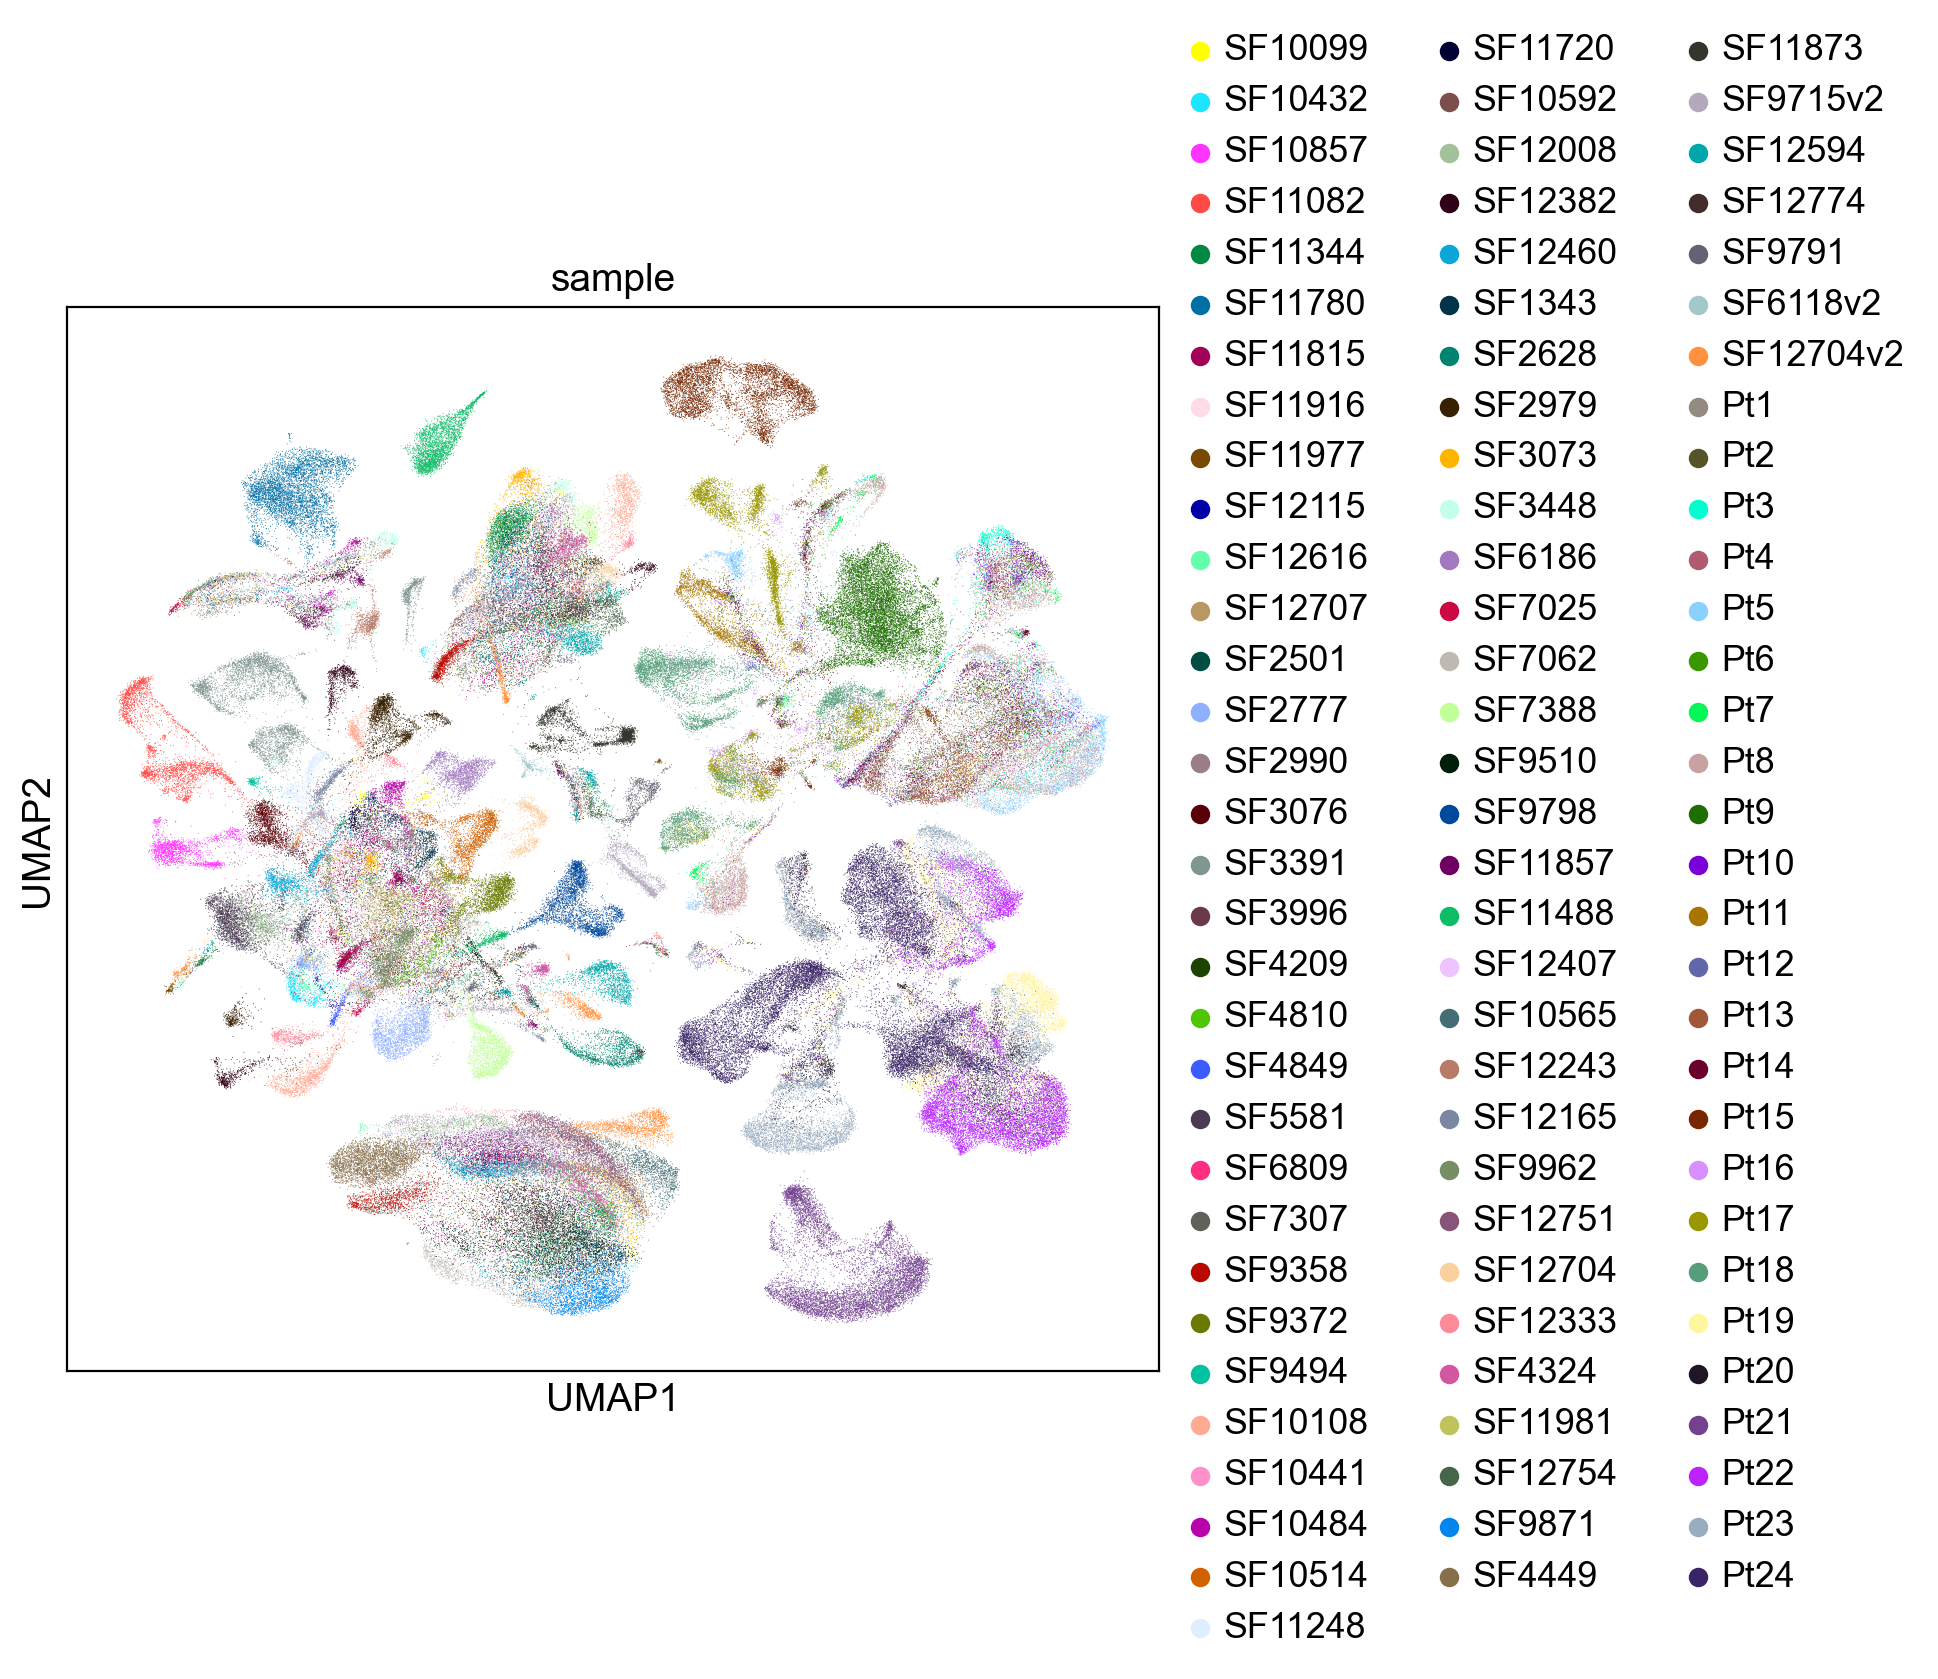

In [11]:
sc.settings.set_figure_params(dpi=100, figsize = (7, 7))
sc.pl.umap(
    adata,
    color = 'sample',
)

# Batch effect correction by scVI

In [ ]:
# pick the top 3000 highly variable genes
# you can pick more if you had more cells
# 3000 genes in 10000 cells is a good number
# gene 개수가 cell 개수의 절반은 되야 한다는 카더라가 있음
# **나는 안돌림**
sc.pp.highly_variable_genes(adata, n_top_genes = 3000, subset = True, layer = 'counts',
                            flavor = 'seurat_v3', batch_key = 'sample')

In [12]:
# making the scVI model
# GPU 안쓰면 개느림. Cuda <- 필수

scvi.model.SCVI.setup_anndata(
    adata,
    layer = 'counts',
    continuous_covariate_keys = ['pct_counts_mito', 'pct_counts_ribo', 'total_counts'],
    batch_key = 'sample'
)
model = scvi.model.SCVI(
    adata,
    n_layers = 4,
    n_latent = 60,
    gene_likelihood = 'nb',
)

c:\Users\heung\anaconda3\Lib\site-packages\scvi\data\fields\_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [13]:
# model.train(max_epochs = 200)
model.train(max_epochs = 100)   # 1h

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\heung\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 100/100: 100%|██████████| 100/100 [55:48<00:00, 33.44s/it, v_num=1, train_loss_step=5.12e+3, train_loss_epoch=5.29e+3]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [55:48<00:00, 33.49s/it, v_num=1, train_loss_step=5.12e+3, train_loss_epoch=5.29e+3]


In [14]:
# get the latent space
adata.obsm['X_scVI'] = model.get_latent_representation()
# model.get_latent_representation().shape
# 7.3GB (크게 차이 없음)

# get scVI normalized data
adata.layers['scvi_normalized'] = model.get_normalized_expression() # <- 용량 큼 (~30GB)

# running time: 5m 25s for 94 samples

In [15]:
# data type 확인
# adata.layers['counts']
adata.layers['scvi_normalized']

array([[1.2439292e-05, 1.2124512e-05, 3.7257510e-07, ..., 2.1259852e-05,
        4.9144188e-07, 1.7967413e-07],
       [1.3207261e-05, 1.1770975e-05, 2.4499968e-07, ..., 2.9587600e-05,
        4.0043051e-07, 1.6790298e-07],
       [7.5217063e-06, 8.2005336e-06, 3.7019228e-07, ..., 2.0392174e-05,
        2.7151239e-07, 2.6748327e-07],
       ...,
       [3.4872986e-07, 3.1970578e-06, 1.6258038e-08, ..., 2.1892838e-08,
        1.2629903e-09, 8.4309804e-09],
       [3.0238800e-07, 4.3555615e-06, 1.0180546e-08, ..., 2.6372678e-08,
        1.5859244e-09, 8.0976275e-09],
       [4.0134938e-07, 6.4992937e-06, 3.4935198e-08, ..., 1.0195898e-08,
        2.0785345e-09, 2.9686533e-09]], dtype=float32)

# Batch regression 확인

In [16]:
# 기본적인 clustering
# sc.pp.pca(adata)
sc.pp.neighbors(adata, use_rep = 'X_scVI')
sc.tl.umap(adata)

# running time: 1m 51s
# running time: 2m 23s for 94 samples

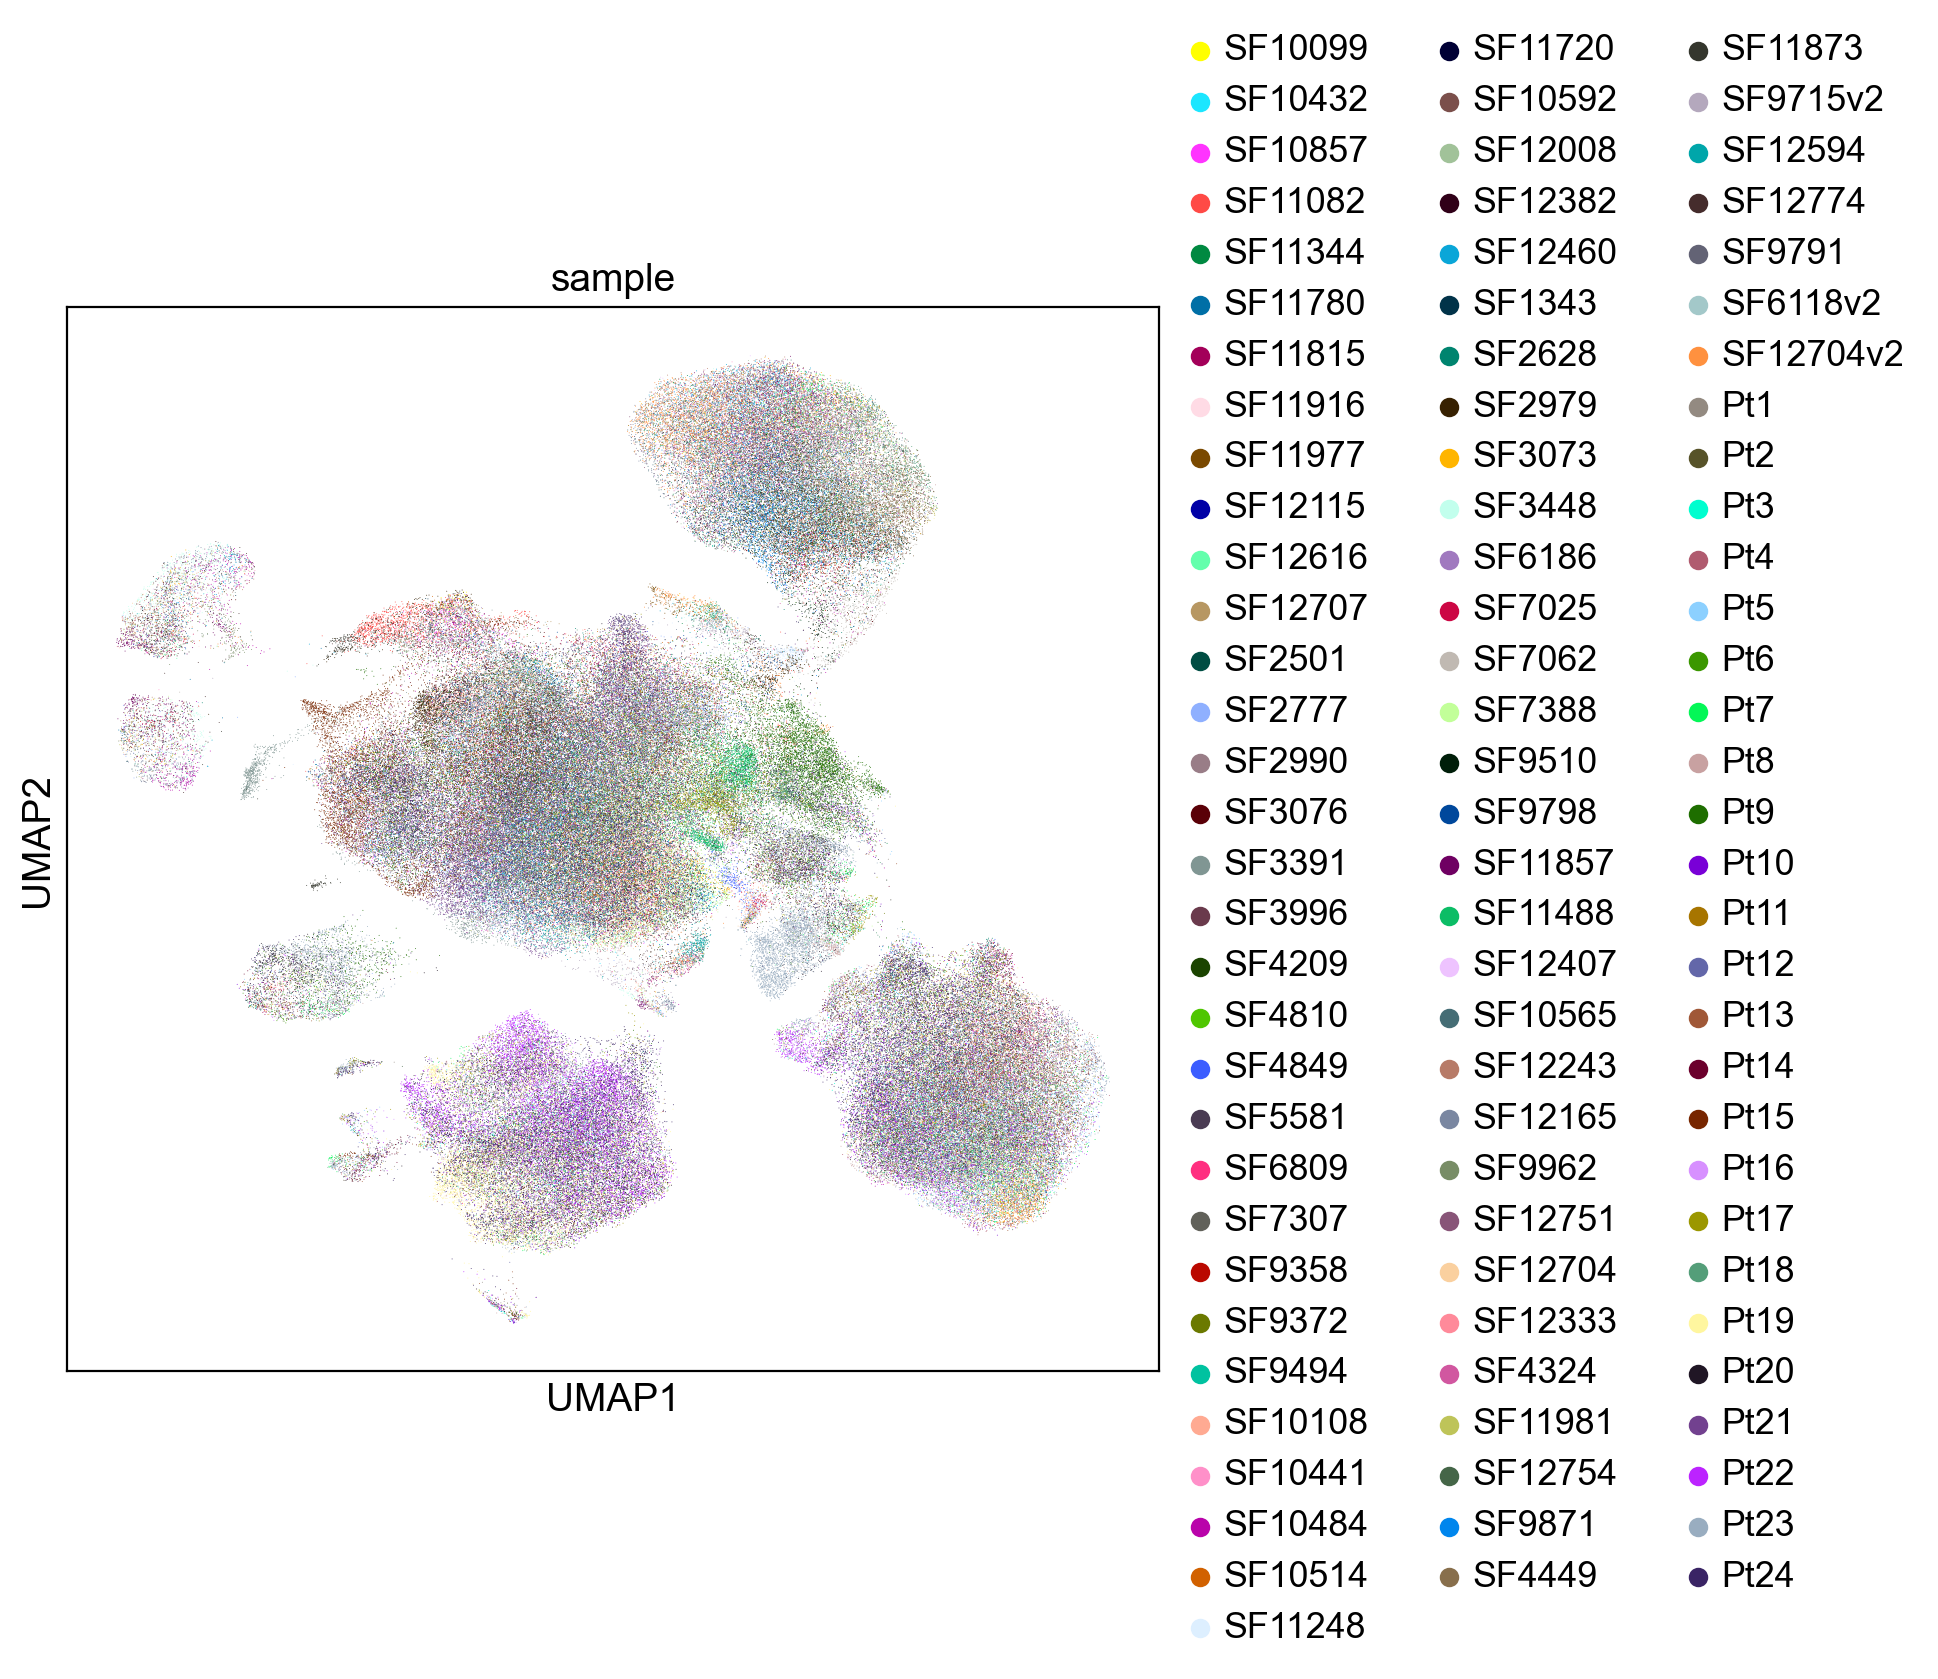

In [49]:
sc.settings.set_figure_params(dpi=100, figsize = (7, 7))

sc.pl.umap(
    adata,
    color = ['sample'],
)

In [46]:
# Clustering
sc.tl.leiden(adata, resolution=1)

# run time: 1m 46s for 94 samples scVI

In [50]:
adata

AnnData object with n_obs × n_vars = 278304 × 34234
    obs: 'sample', 'n_genes', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'n_cells'
    uns: 'pca', 'neighbors', 'umap', 'sample_colors', '_scvi_uuid', '_scvi_manager_uuid', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap', '_scvi_extra_continuous_covs', 'X_scVI'
    varm: 'PCs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'distances', 'connectivities'

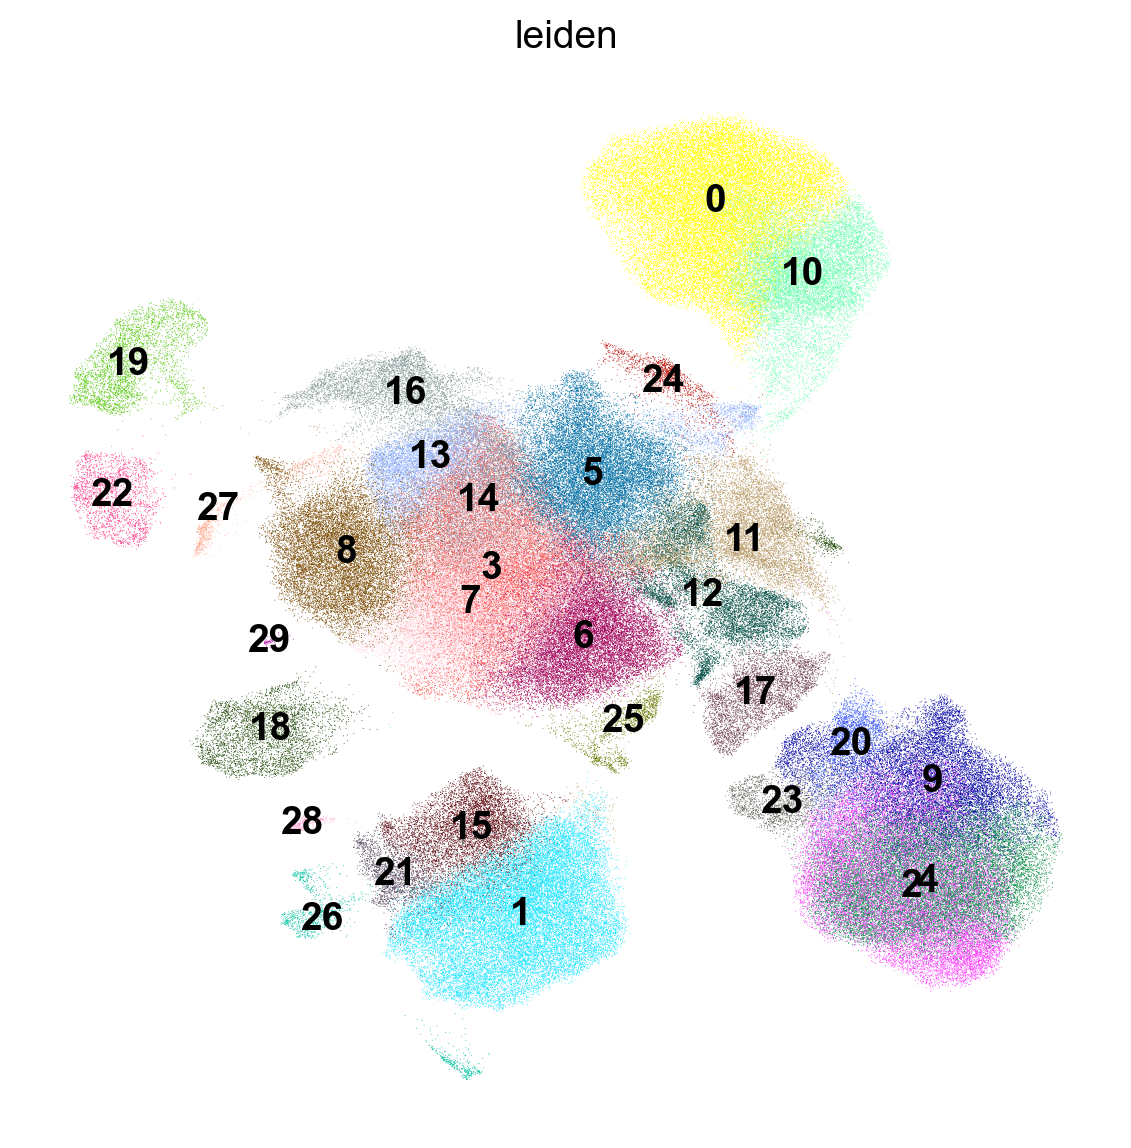

In [53]:
rcParams['figure.figsize'] = (7, 7)

sc.pl.umap(
    adata,
    color = ['leiden'],
    frameon = False,
    legend_loc = 'on data',
    layer = 'scvi_normalized',
    color_map = 'rainbow',
    palette = sc.pl.palettes.default_102,
    # groups = ['7']
)

# Save the integrated data and scVI model

In [ ]:
import numpy as np
count_non_zeros = np.count_nonzero(adata.layers['scvi_normalized'])
count_zeros = adata.layers['scvi_normalized'].size - count_non_zeros
print(count_non_zeros)
print(count_zeros)


In [55]:
adata.write_h5ad(folder_path + "adata_scVI.h5ad")
model.save(folder_path + 'model/')  # trained model 저장
# running time: 3m 42s for 94 samples
# .h5ad file: 44.5GB
# model: 89MB